In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set up data

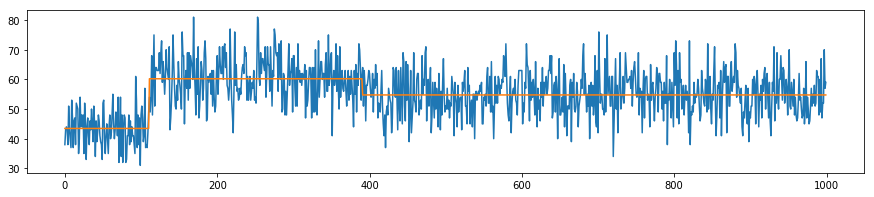

In [11]:
t = 1000
nbreak = 3
tbreak = np.sort(np.random.randint(100, 900, nbreak-1))
theta = np.random.exponential(25, size=nbreak)
theta_t = np.zeros(t)
theta_t[:tbreak[0]] = theta[0]
theta_t[tbreak[0]:tbreak[1]] = theta[1]
theta_t[tbreak[1]:] = theta[2]
y = np.random.poisson(theta_t)

_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(range(t), y)
ax.plot(theta_t);

## Ordered transformation
It is still [WIP](https://github.com/pymc-devs/pymc3/pull/2637), cherrypicking the code from the PR below:

In [12]:
import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform, Transform

class Ordered(ElemwiseTransform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        x, = draw_values([x], point=point)
        return self.forward(x)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

ordered = Ordered()


class Composed(Transform):
    def __init__(self, transform1, transform2):
        self._transform1 = transform1
        self._transform2 = transform2
        self.name = '_'.join([transform1.name, transform2.name])

    def forward(self, x):
        return self._transform2.forward(self._transform1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._transform1.backward(self._transform2.backward(y))

    def jacobian_det(self, y):
        y2 = self._transform2.backward(y)
        det1 = self._transform1.jacobian_det(y2)
        det2 = self._transform2.jacobian_det(y)
        return det1 + det2

## Using switch-like

In [17]:
mu = np.log(y.mean())
sd = np.log(y.std())
t_ = np.linspace(0., 1., t)

with pm.Model() as m:
    lambdas = pm.Normal('lambdas', mu, sd=sd, shape=nbreak)
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    b = pm.Beta('b', 1., 1., shape=nbreak-1, transform=trafo,
                    testval=[0.3, 0.5])
    index_t = tt.switch(tt.gt(t_, b[0])*tt.lt(t_, b[1]), 1, 0) + \
              tt.switch(tt.gt(t_, b[1]), 2, 0)
    theta_ = pm.Deterministic('theta', tt.exp(lambdas[index_t]))
    obs = pm.Poisson('obs', theta_, observed=y)
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_logodds_ordered__, lambdas]
100%|██████████| 2000/2000 [05:35<00:00,  5.96it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


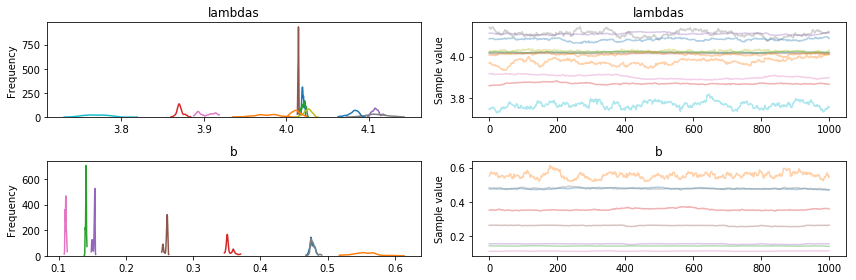

In [18]:
pm.traceplot(trace, varnames=['lambdas', 'b']);

Switch mess up the smooth geometry of the parameter space, which makes sampling using NUTS difficult. Other sampler with much larger sample could handle this particular case, but would break down with more breakpoints or less data (i.e., less information). Instead:
## Approximate with a continous function

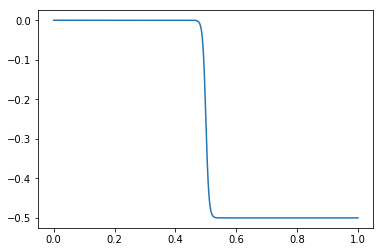

In [41]:
def logistic(L, x0, k, t_):
    return L/(1+np.exp(-k*(t_-x0)))
plt.plot(t_, logistic(-.5, 0.5, 200, t_));

In [47]:
def logistic(L, x0, k=500, t=np.linspace(0., 1., 1000)):
    return L/(1+tt.exp(-k*(t_-x0)))

with pm.Model() as m2:
    lambda0 = pm.Normal('lambda0', mu, sd=sd)
    lambdad = pm.Normal('lambdad', 0, sd=sd, shape=nbreak-1)
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    b = pm.Beta('b', 1., 1., shape=nbreak-1, transform=trafo,
                    testval=[0.3, 0.5])
    theta_ = pm.Deterministic('theta', tt.exp(lambda0 +
                                              logistic(lambdad[0], b[0]) +
                                              logistic(lambdad[1], b[1])))
    obs = pm.Poisson('obs', theta_, observed=y)
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_logodds_ordered__, lambdad, lambda0]
100%|██████████| 2000/2000 [00:09<00:00, 207.14it/s]
The number of effective samples is smaller than 25% for some parameters.


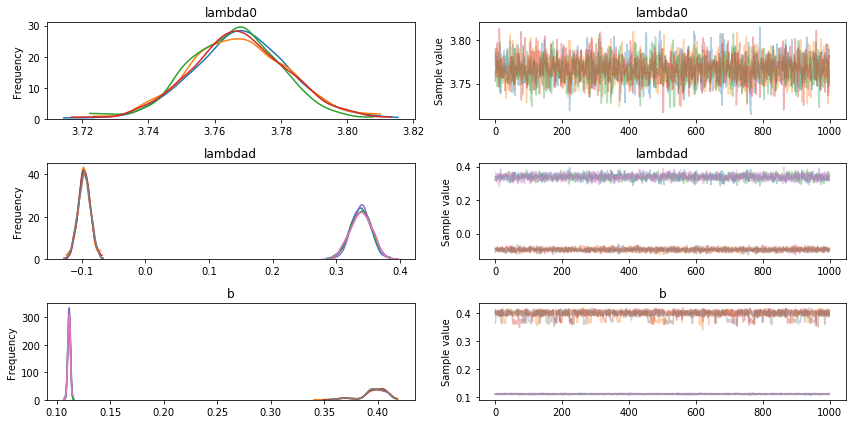

In [48]:
pm.traceplot(trace, varnames=['lambda0', 'lambdad', 'b']);

## Display fit

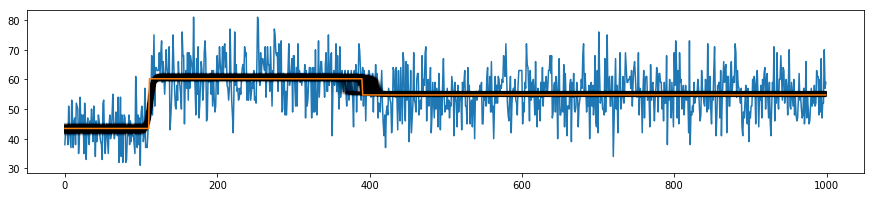

In [49]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(range(t), y)
ax.plot(trace['theta'].T, alpha=.01, color='k')
ax.plot(theta_t);

The parameter `k` (i.e., slope) that controls how rapid the change could also be modelled as a free parameters.